In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from re import L
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [74]:
# Load the dataset
df = pd.read_excel('G:\My Drive\Drilling\Drilling_Data.xls')
df.head()

,MD,ROP,ROP.1,WOB,WOB.1,BIT_RPM,TRQ,SPP,Flow In,SPM,...,Actpitv,HOOKLOAD,CSIP,P ovb For Soft formation,P ovb For Hard formation,P ovb,d,D adjust,PP Zamora Method,PP Eaton Method
0,m,min/m,m/min,klb,Kgr,rpm,klb.ft,Psi,gal/min,rev,...,bbl,klb,psi,NaN,NaN,psi,No UNIT,No unit,PSI,psi
1,15,19.586777,0.051055,5.148,2.337192,50,0.206517,50,525,70,...,454.6412,71.5,0,0.956864,0.990307,0.973586,0.748452,0.741271,8.586818,8.759359
2,16,10.84991,0.092167,2.51325,1.141016,50,0.55317,50,536,72,...,584.1523,74.12625,0,0.952302,0.985802,0.969052,0.675194,0.668723,8.586906,8.759317
3,17,4.559271,0.219333,2.349,1.066446,50,0.346653,50,568.233972,138,...,545.6575,74.14425,0,0.948116,0.981680,0.964898,0.616149,0.610241,8.586865,8.759409
4,18,4.231312,0.236333,1.971,0.894834,50,0.228644,167,604.161364,146,...,536.4112,74.5335,0,0.944257,0.977890,0.961073,0.604458,0.598664,8.58689,8.759426


In [75]:
# Drop unnecessary features
df = df.drop(
    ['MD', 'WOB', 'TRQ', 'SPP', 'Flow In', 'SPM', 'Actpitv', 'HOOKLOAD', 'CSIP',
     'P ovb For Soft formation', 'P ovb For Hard formation', 'P ovb', 'd',
     'D adjust', 'PP Eaton Method'], axis=1
)
df = df.drop(0, axis=0)
df = df.reset_index(drop=True)
df.head()

,ROP,ROP.1,WOB.1,BIT_RPM,MWI,MWO,PP Zamora Method
0,19.586777,0.051055,2.337192,50,64.518444,65.143444,8.586818
1,10.84991,0.092167,1.141016,50,64.587152,65.212152,8.586906
2,4.559271,0.219333,1.066446,50,64.555458,65.180458,8.586865
3,4.231312,0.236333,0.894834,50,64.574378,65.199378,8.58689
4,3.367003,0.297,0.726287,50,64.586844,65.211844,8.586905


In [76]:
# Convert to numeric features
numeric_columns = ['ROP', 'ROP.1', 'WOB.1', 'BIT_RPM', 'MWI', 'MWO',
                   'PP Zamora Method']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

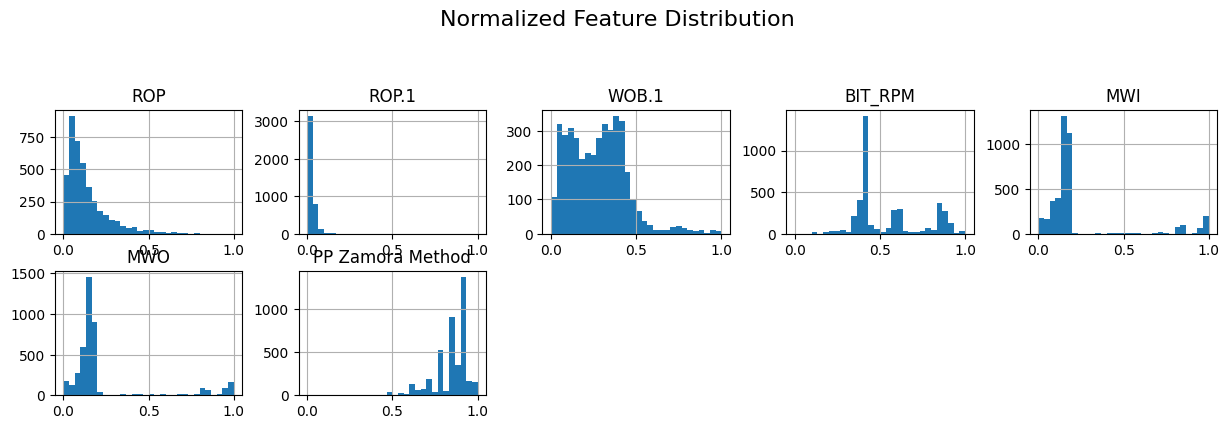

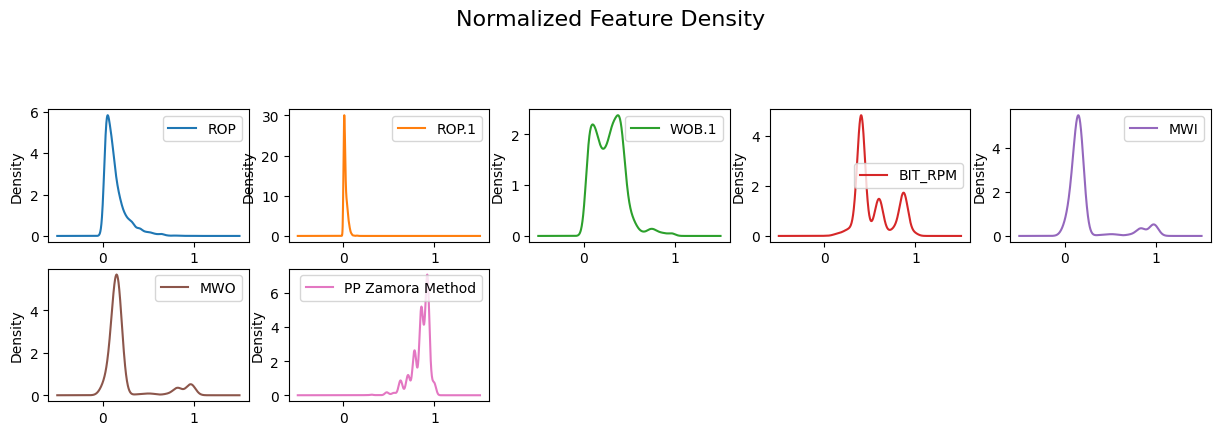

In [77]:
# Plot histograms for normalized data

df_normalized = (df - df.min()) / (df.max() - df.min())  # Min-max normalization

df_normalized.hist(figsize=(15, 10), bins=30, layout=(5, 5))
plt.suptitle("Normalized Feature Distribution", fontsize=16)
plt.show()

# Alternatively, density plot
df_normalized.plot(kind='density', subplots=True, layout=(5, 5), figsize=(15, 10), sharex=False)
plt.suptitle("Normalized Feature Density", fontsize=16)
plt.show()


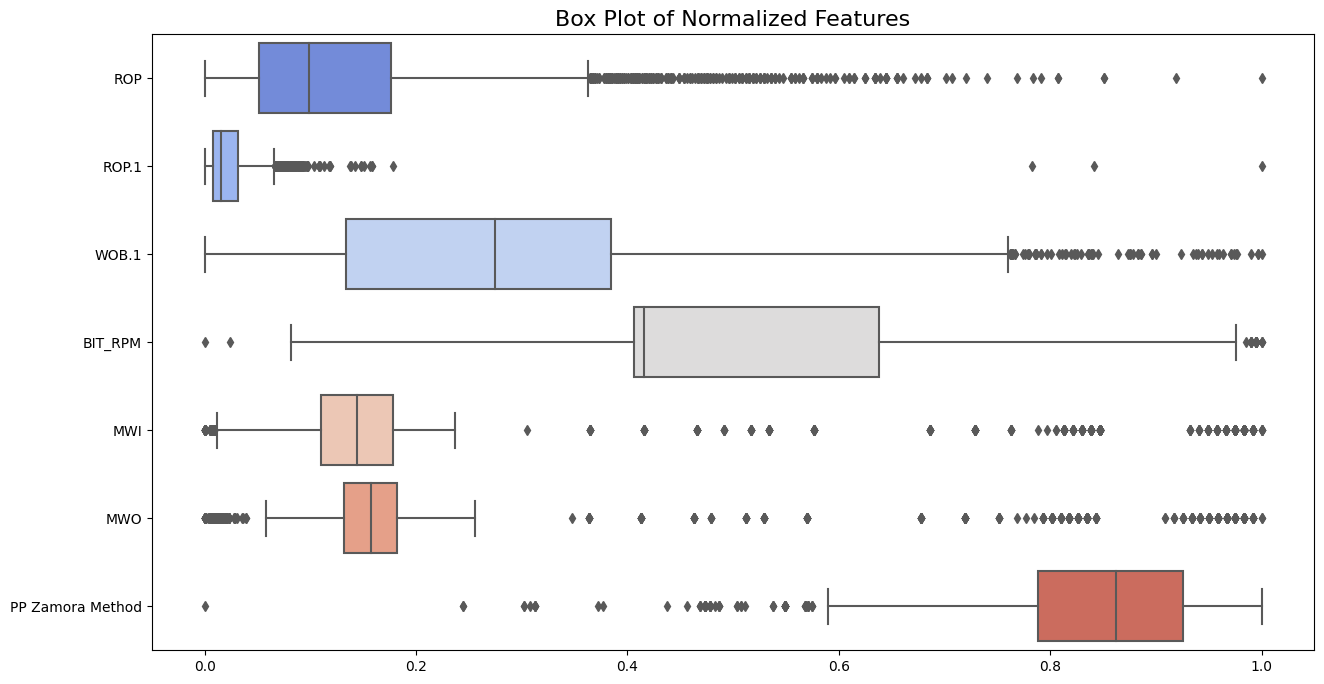

In [78]:
# Box Plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_normalized, orient='h', palette="coolwarm")
plt.title("Box Plot of Normalized Features", fontsize=16)
plt.show()


In [79]:
# Separate features and target
X = df.drop('PP Zamora Method', axis=1)
y = df['PP Zamora Method']

# Transformation to Reduce Skewness - Apply log(1+x) transformation to reduce skewness
df_transformed = df.copy()
for col in df_transformed.columns:
    df_transformed[col] = np.log1p(df_transformed[col])

X_transformed = df_transformed.drop('PP Zamora Method', axis=1)

# Train/test split on transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("\nBaseline Linear Regression (With Transformation and Scaling):")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

# Ridge Regression (To Handle Outliers and Reduce Overfitting)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

print("\nRidge Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_ridge))
print("Train R2 Score:", r2_score(y_train, y_train_pred_ridge))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_ridge))
print("Test R2 Score:", r2_score(y_test, y_test_pred_ridge))

# Random Forest Regressor (Handling Nonlinear Relationships and Outliers)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Regressor:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_rf))
print("Train R2 Score:", r2_score(y_train, y_train_pred_rf))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_rf))
print("Test R2 Score:", r2_score(y_test, y_test_pred_rf))

# Check for Overfitting and Underfitting - Calculate performance gaps between train and test sets
lr_train_test_gap = r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred)
ridge_train_test_gap = r2_score(y_train, y_train_pred_ridge) - r2_score(y_test, y_test_pred_ridge)
rf_train_test_gap = r2_score(y_train, y_train_pred_rf) - r2_score(y_test, y_test_pred_rf)

print("\nOverfitting/Underfitting Analysis:")
print(f"Linear Regression Train-Test R2 Gap: {lr_train_test_gap:.4f}")
print(f"Ridge Regression Train-Test R2 Gap: {ridge_train_test_gap:.4f}")
print(f"Random Forest Train-Test R2 Gap: {rf_train_test_gap:.4f}")



Baseline Linear Regression (With Transformation and Scaling):
Train MSE: 1.364066671502974e-06
Train R2 Score: 0.999859404917546
Test MSE: 8.409898833726393e-07
Test R2 Score: 0.9999143132459137

Ridge Regression:
Train MSE: 4.635596185423026e-06
Train R2 Score: 0.9995222066182478
Test MSE: 4.756823036993273e-06
Test R2 Score: 0.9995153369453528

Random Forest Regressor:
Train MSE: 2.5190158990251548e-05
Train R2 Score: 0.9974036368205074
Test MSE: 0.00013112085338489935
Test R2 Score: 0.9866403620998171

Overfitting/Underfitting Analysis:
Linear Regression Train-Test R2 Gap: -0.0001
Ridge Regression Train-Test R2 Gap: 0.0000
Random Forest Train-Test R2 Gap: 0.0108


In [80]:
# Cross-validation for Linear Regression
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nCross-Validation R² Scores for Linear Regression:", cv_scores)
print("Mean CV R² Score:", np.mean(cv_scores))



Cross-Validation R² Scores for Linear Regression: [0.9998805  0.99969942 0.99990668 0.99989144 0.99992163]
Mean CV R² Score: 0.9998599330287856


In [81]:
# Example: New data input 
new_data = {
    'ROP': [19.58],
    'ROP.1': [0.05],
    'WOB.1': [2.33],
    'BIT_RPM': [50],
    'MWI': [64.51],
    'MWO': [65.14],
}

# Convert the dictionary to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Apply Log Transformation
new_data_transformed = new_data_df.copy()
for col in new_data_transformed.columns:
    new_data_transformed[col] = np.log1p(new_data_transformed[col])

# Apply Robust Scaling 
new_data_scaled = scaler.transform(new_data_transformed)

# Make Predictions with Each Model
# Linear Regression Prediction
linear_pred = lr.predict(new_data_scaled)

# Ridge Regression Prediction
ridge_pred = ridge.predict(new_data_scaled)

# Random Forest Prediction
rf_pred = rf.predict(new_data_scaled)

# Display the predictions
print("\nPredictions for New Data:")
print(f"Linear Regression Prediction: {linear_pred[0]}")
print(f"Ridge Regression Prediction: {ridge_pred[0]}")
print(f"Random Forest Prediction: {rf_pred[0]}")



Predictions for New Data:
Linear Regression Prediction: 8.585599090304537
Ridge Regression Prediction: 8.584758942939152
Random Forest Prediction: 8.58683270665427
